## Project: Predicting house sale prices
## Part 2: Test sample scoring and final model selection
**Data:** housing data for the city of Ames, Iowa, USA, 2006 to 2010  
**Data description:** https://s3.amazonaws.com/dq-content/307/data_description.txt  
**Source:** https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627  
**Source pdf:** https://www.tandfonline.com/doi/pdf/10.1080/10691898.2011.11889627?needAccess=true


In [62]:
# Set-up auto-reload functions for faster debugging 
# (automatically refreshes changes in subpackages codes)
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# Import parent directory (main project directory)
# for packages importing
import sys
import os

# Getting the parent directory name in which your script is running
parent = os.path.dirname(os.path.realpath(''))

# adding the parent directory to
# the sys.path.
sys.path.append(parent)

# now we can import the module in the parent
# directory.

In [64]:
# Project packages import
import gp23package.data.make_dataset as gp23md
import gp23package.explore_visualise.eda as gp23eda
import gp23package.features.build_features as gp23feat
import gp23package.models.hyperparameters_model as gp23hyperparam
import gp23package.models.train_model as gp23train
import gp23package.utils.diagnostics as gp23diag

# Pylance highligting package issue (not to be worried about)
# https://github.com/microsoft/pylance-release/blob/main/TROUBLESHOOTING.md#unresolved-import-warnings

# Standard Python libraries import
from IPython.display import display, HTML #  tidied-up display
from time import time #  project timer
from itertools import chain # for list iterations

# plots
import matplotlib.pyplot as plt
import seaborn as sn

# Statistics
from scipy import stats
from scipy.stats import mstats

# Sklearn
from sklearn.feature_selection import (SelectKBest, chi2, f_regression, RFE, mutual_info_regression,
                                      SequentialFeatureSelector, SelectFromModel)
from sklearn.preprocessing import (normalize, MinMaxScaler)
from sklearn.metrics import (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score)
from sklearn.model_selection import (train_test_split, cross_val_score, KFold, GridSearchCV)
from sklearn.linear_model import (LinearRegression, Ridge, ElasticNet, Lasso, TheilSenRegressor, RANSACRegressor,
                                  HuberRegressor , SGDRegressor, Lars, ElasticNet, RidgeCV)

#statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import statsmodels as sm
import statsmodels.stats.stattools as smt
import statsmodels.stats.diagnostic as smd

# Other
from dython import nominal # Correlations between categorical variables

# Necessary packages
import gp23package
import numpy as np
import pandas as pd
import pickle # dump models

#turning on plot display in JN
%matplotlib inline 
# Setting pandas display options
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 250

### 8. Importing models & data transformations

In [65]:
# Starting project timer
tic_all = time()

In [66]:
#Loading saved models and transformation objects
filename = 'model_list.sav'
file = os.path.join(parent, 'models', filename)
with open(file, 'rb') as file_open:
    model_list = pickle.load(file_open)

filename = 'boxCox_dict.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    boxCox_dict = pickle.load(file_open)

filename = 'data_optbin.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    data_optbin = pickle.load(file_open)

filename = 'var_dict.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    var_dict = pickle.load(file_open)

# Load train / valid results of models
filename = 'chosen_bestModels.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    chosen_bestModels = pickle.load(file_open)

# Loading test datasets
filename = 'X_test.csv'
file = os.path.join(parent, 'data\interim', filename)
X_test = pd.read_csv(file, index_col=0)

filename = 'y_test.csv'
file = os.path.join(parent, 'data\interim', filename)
y_test = pd.read_csv(file, index_col=0).squeeze("columns")

# Loading variable lists

filename = 'discrete.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    discrete = pickle.load(file_open)

filename = 'categorical.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    categorical = pickle.load(file_open)

filename = 'continuous.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    continuous = pickle.load(file_open)

# Load train/valid scaler too keep same transformations on production scoring
filename = 'train_scaler.sav'
file = os.path.join(parent, 'data\processed', filename)
with open(file, 'rb') as file_open:
    train_scaler = pickle.load(file_open)


### 9. Scoring new data - test dataset
#### 9.1 Applying transformations to new data

In [67]:
# MANUAL_INPUT
# Scoring new vector of data
# For this we need to have list of used variables for final models
# If we have more than one model we would have to prepare more list concatenating all lists
# Attention: for scoring we do need to use original variable list with exactly the same order of variables
# In our current case var_dict["BKWD_20"]

scoring_vars = list(set(var_dict["BKWD_20"] + var_dict["FWD_10"]))
scoring_dict = var_dict

scoring_varsRaw = []
# List of prefixes differentiating engineered variables from original variables
prefixes = ["WOE_", "Box_"]

# taking all variable variations for final models
for var in chosen_bestModels["variable_set"].unique():
    # for each variable in variable set
    for i in var_dict[var]:
        # Removing prefixes from prefixes list
        for prefix in prefixes:
            i = i.removeprefix(prefix)
    # Adding raw variable name to scoring vars (if there are more than 1 variable lists there can be duplicates)
        scoring_varsRaw.append(i)

# Deduplicating variable names
# Final list will probably come in different order than used source lists
scoring_varsRaw = list(set(scoring_varsRaw))
print('*** raw scoring_vars ***')
print(scoring_varsRaw,'\n')

# Remark: in this project we divided data to train_valid / test samples after preliminary cleaning. In real-world cases
# we will not have access to incoming data, hence all the preliminary data cleaning would have to be done on new data
# as well. 

# Limiting number of input variables
X_test = X_test[scoring_varsRaw]

# Transforming y metric
# we are not winsorizing test data outcome variable as this would lead to false fit metrics
y2_test = np.log(y_test) 

# Creating empty subset of final scoring variavbles (engineered)
scoringFinal_vars = list(set(scoring_varsRaw).intersection(discrete))
print('*** discrete variables intersection ***')
print(scoringFinal_vars,'\n')
print('*** Variables used for scoring ***')
print(scoring_vars,'\n')

*** raw scoring_vars ***
['Garage Area', 'Overall Cond', 'BsmtFin Type 1', 'Neighborhood', 'MS SubClass', 'Central Air', 'Condition 1', 'TotRms AbvGrd', 'Kitchen Qual', 'Heating QC', 'Full Bath', 'Overall Qual', 'Bsmt Full Bath', 'House Style', '2nd Flr SF', 'Functional', 'MS Zoning', 'Bsmt Qual', 'Bathroom_total', 'Bsmt Exposure', 'Sale Condition', 'Floor_area_ratio', 'Bsmt Half Bath', 'Fireplaces'] 

*** discrete variables intersection ***
['Bsmt Full Bath', 'Overall Cond', 'Bsmt Qual', 'TotRms AbvGrd', 'Bathroom_total', 'Kitchen Qual', 'Heating QC', 'Full Bath', 'Overall Qual', 'Central Air', 'Bsmt Half Bath', 'Fireplaces'] 

*** Variables used for scoring ***
['WOE_MS SubClass', 'Overall Cond', 'WOE_MS Zoning', 'Central Air', 'WOE_Bsmt Exposure', 'WOE_Functional', 'TotRms AbvGrd', 'Kitchen Qual', 'Heating QC', 'Full Bath', 'Overall Qual', 'WOE_Sale Condition', 'WOE_BsmtFin Type 1', 'WOE_Condition 1', 'Box_Floor_area_ratio', 'Bsmt Full Bath', 'Bsmt Qual', 'Bathroom_total', 'Box_Gara

In [68]:
# Transforming input variables
# WoE transformation for categorical variables (common values between categorical vars and scoring_vars)
for i in set(categorical).intersection(scoring_varsRaw) :
    X_test["WOE_"+i] = data_optbin.transform(data = X_test, var_name = i)   
# Box-Cox power transformation for continuous variables (common values between continuous and scoring_vars)
# We use lambdas from boxCox_dict dictionary (lambda values calculated on train_valid dataset). This is to prevent
# Target information leakage between samples
for i in set(continuous).intersection(scoring_varsRaw) :
    X_test["Box_"+i] = stats.boxcox(x = X_test[i]+1 , lmbda = boxCox_dict[i])

Neighborhood : Landmrk  - value is not present in the  binning table
MS SubClass : C150  - value is not present in the  binning table


In [69]:
# Checking
# data_optbin["Neighborhood"]
X_test[X_test["Neighborhood"]=="Landmrk"][["WOE_Neighborhood","Neighborhood"]]

,WOE_Neighborhood,Neighborhood
2788,0.080165,Landmrk


We see here that for 'Neighborhood' variable in test dataset we encountered 'Landmrk' value which has only 1 observation. According to our adopted WOE transformation function we will assign WoE value of "Other" group (least frequent group in binning dictionary)

In [70]:
# Normalizing data using scaler used on train_valid sample (preventing data leakage between samples)
X_test[scoring_vars] = train_scaler.fit_transform(X_test[scoring_vars])

#### 9.2 Test data model performance

In [71]:
# Checking which models performs best on test dataset
test_results = pd.DataFrame()

# iterating through best models
for i in model_list:
    predictions = model_list[i]['model'].predict(X_test[scoring_dict[model_list[i]['variables']]])
    mae = mean_absolute_error(y2_test, predictions)
    mse = mean_squared_error(y2_test, predictions)
    rmse = np.sqrt(mean_squared_error(y2_test, predictions))
    r2 = r2_score(y2_test, predictions)
    temp_df = pd.DataFrame(data = {'rmse': rmse, 'r_squared': r2, 'mae' : mae, 'mse' : mse} , index=[i])
    test_results = pd.concat([test_results, temp_df])

test_results.sort_values(by="r_squared", ascending = False, inplace = True)
test_results

,rmse,r_squared,mae,mse
model6_theil,0.154294,0.853212,0.118670,0.023807
model5_huber,0.166747,0.828562,0.129958,0.027804
model4_ridge,0.167265,0.827495,0.130514,0.027978
model3_elasticNet,0.167484,0.827042,0.130680,0.028051
model2_lasso,0.167544,0.826919,0.130729,0.028071
model1_lr,0.167555,0.826895,0.130739,0.028075


Theil model (which was previously worst performing on train/valid cross validation) is the best fitted model to test data.

#### 9.4 Performance stability

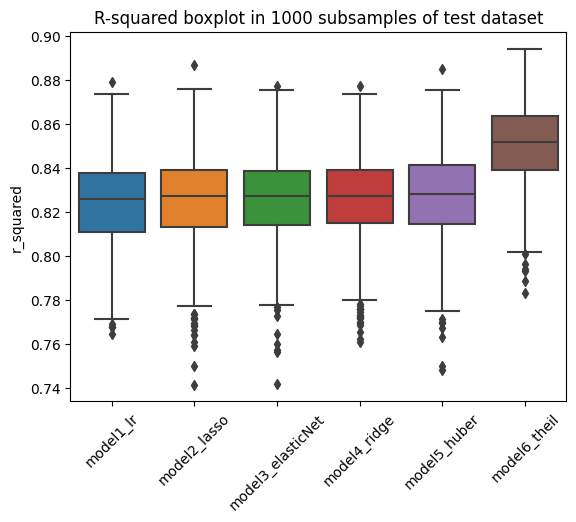

Test sample size -  234
R-squared standard deviation by model on test samples
model1_lr            0.019308
model2_lasso         0.020015
model3_elasticNet    0.019481
model4_ridge         0.018760
model5_huber         0.019726
model6_theil         0.017470
Name: r_squared, dtype: float64
RMSE standard deviation by model on test samples
model1_lr            0.006378
model2_lasso         0.006641
model3_elasticNet    0.006696
model4_ridge         0.006361
model5_huber         0.006604
model6_theil         0.007629
Name: rmse, dtype: float64


In [72]:
# Checking heteroscedasticity influence on sampling from test dataset
test_sampling = X_test[scoring_vars].merge(y2_test, left_index = True, right_index = True)
sampleTests_results = pd.DataFrame()

# Sampling 1000x 40% observations from test dataset and checking model performance
for model in model_list:
    for i in range(1000):
        test = test_sampling.sample(frac=0.40)
        test_pred = model_list[model]['model'].predict(test[scoring_dict[model_list[model]['variables']]])
        mae = mean_absolute_error(pd.Series(test["SalePrice"]), test_pred)
        mse = mean_squared_error(test["SalePrice"], test_pred)
        rmse = np.sqrt(mean_squared_error(test["SalePrice"], test_pred))
        mape = mean_absolute_percentage_error(test["SalePrice"], test_pred)
        r2 = r2_score(test["SalePrice"], test_pred)
        temp_df = pd.DataFrame(data = {'rmse': rmse, 'r_squared': r2, 'mae' : mae, 'mse' : mse,
                                       'iteration' : i} , index=[model])
        sampleTests_results = pd.concat([sampleTests_results, temp_df])
        
sn.boxplot(x = sampleTests_results.index, y = 'r_squared', data = sampleTests_results)
plt.xticks(rotation = 45)
plt.title('R-squared boxplot in 1000 subsamples of test dataset')
plt.show()
print('Test sample size - ',int(0.4*len(test_sampling)))
print('R-squared standard deviation by model on test samples')
print(sampleTests_results.groupby(sampleTests_results.index)["r_squared"].std())
print('RMSE standard deviation by model on test samples')
print(sampleTests_results.groupby(sampleTests_results.index)["rmse"].std())

Altough not suggested by train/valid performance Thiel-Sen regression is performing significantly better on test dataset. All regressions seems to be pretty stable on randomly generated subsamples (however test dataset has only 586 observations total). 

#### 9.5 Model diagnostics

*** Test data residuals statistics ***


,predicted,actual,residual
count,586.000000,586.000000,586.000000
mean,11.972545,12.031167,0.058621
std,0.447563,0.403064,0.157024
min,10.747072,10.463103,-0.591283
25%,11.665435,11.784380,-0.048080
50%,11.988061,12.013670,0.053454
75%,12.258654,12.276936,0.154007
max,13.176154,13.321214,0.584328


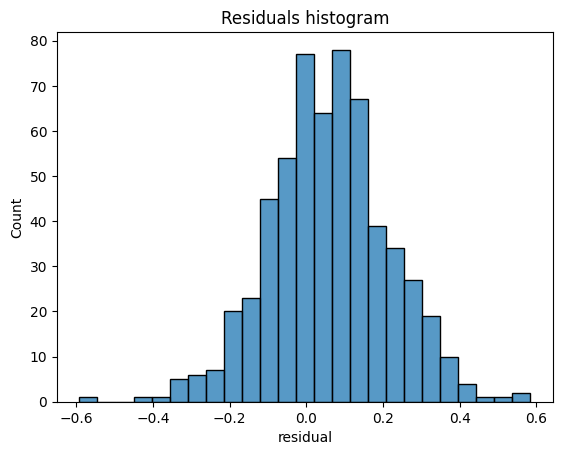

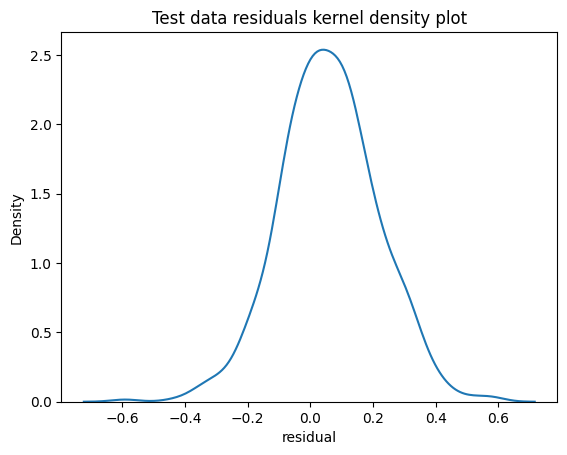

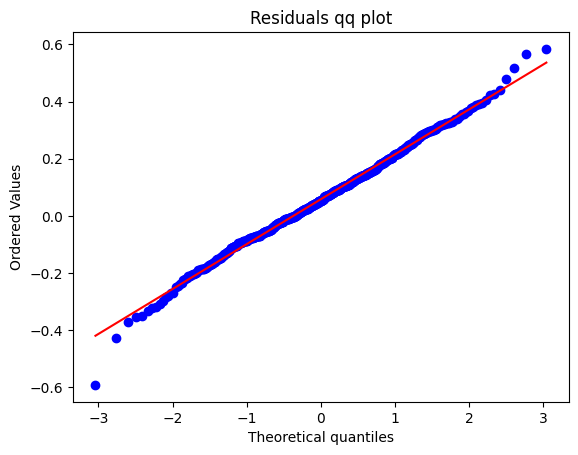

*** Jarque-Bera test for normality of residuals ***
[('Jarque-Bera', 8.138798127121909), ('Chi^2 two-tail prob.', 0.017087654016673025), ('Skew', -0.020571329348699645), ('Kurtosis', 3.5758792388714573)]
On 0.05 significance level we  reject H0 about normal distribution of residuals.

Shapiro-Wilk test for normality
ShapiroResult(statistic=0.9959295988082886, pvalue=0.13402307033538818)
On 0.05 significance level we fail to reject H0  that residuals come from a normal distribution.

Anderson-Darling test for normality
Statistic: 0.495
Significance level - 15.000: 0.572 (Critical  Value), fail to reject H0 that sample comes from  normal distribution.
Significance level - 10.000: 0.652 (Critical  Value), fail to reject H0 that sample comes from  normal distribution.
Significance level - 5.000: 0.782 (Critical  Value), fail to reject H0 that sample comes from  normal distribution.
Significance level - 2.500: 0.912 (Critical  Value), fail to reject H0 that sample comes from  normal distrib

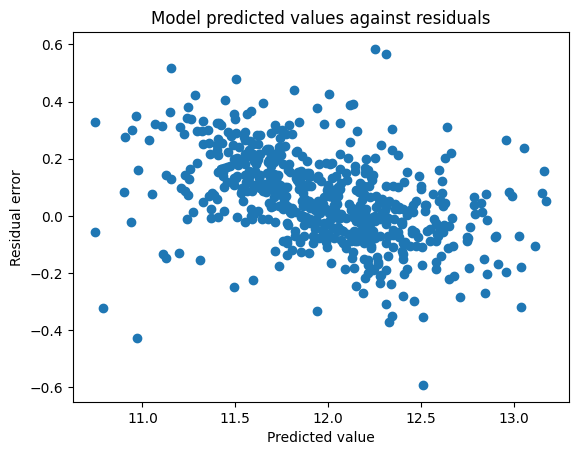

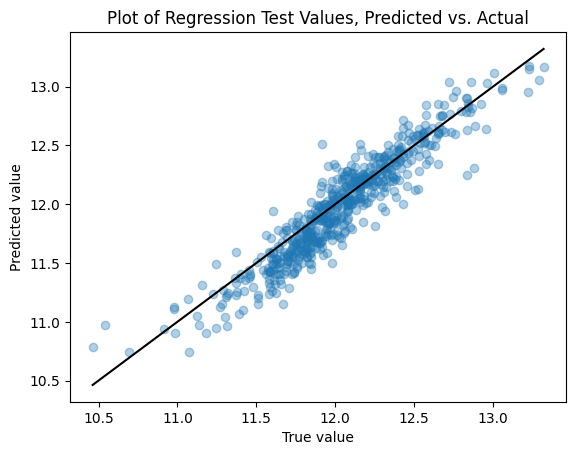

*** Breusch-Pagan homoscedasticity test***
[('Lagrange multiplier statistic', 184.48057190572325), ('p-value', 4.047982504290017e-29), ('f-value', 13.00260913827095), ('f p-value', 4.1859331602983895e-35)]
On 0.05 significance level we reject H0 and  assume heteroscedasticity of residuals.

*** Investigating Multicollinearity ***
*** Variance Inflation Factor (VIF) table***


,feature,VIF
0,WOE_Functional,62.190636
1,WOE_Sale Condition,11.149712
2,WOE_Bsmt Exposure,17.258684
3,WOE_MS SubClass,10.998550
4,WOE_Condition 1,20.525392
5,WOE_BsmtFin Type 1,21.854058
6,WOE_MS Zoning,18.304818
7,WOE_Neighborhood,9.724910
8,Box_Garage Area,12.431502
9,Box_Floor_area_ratio,23.318890


There is indication (VIF > 5) that multicollinearity is  present in the data.

*** Correlation Matrix ***


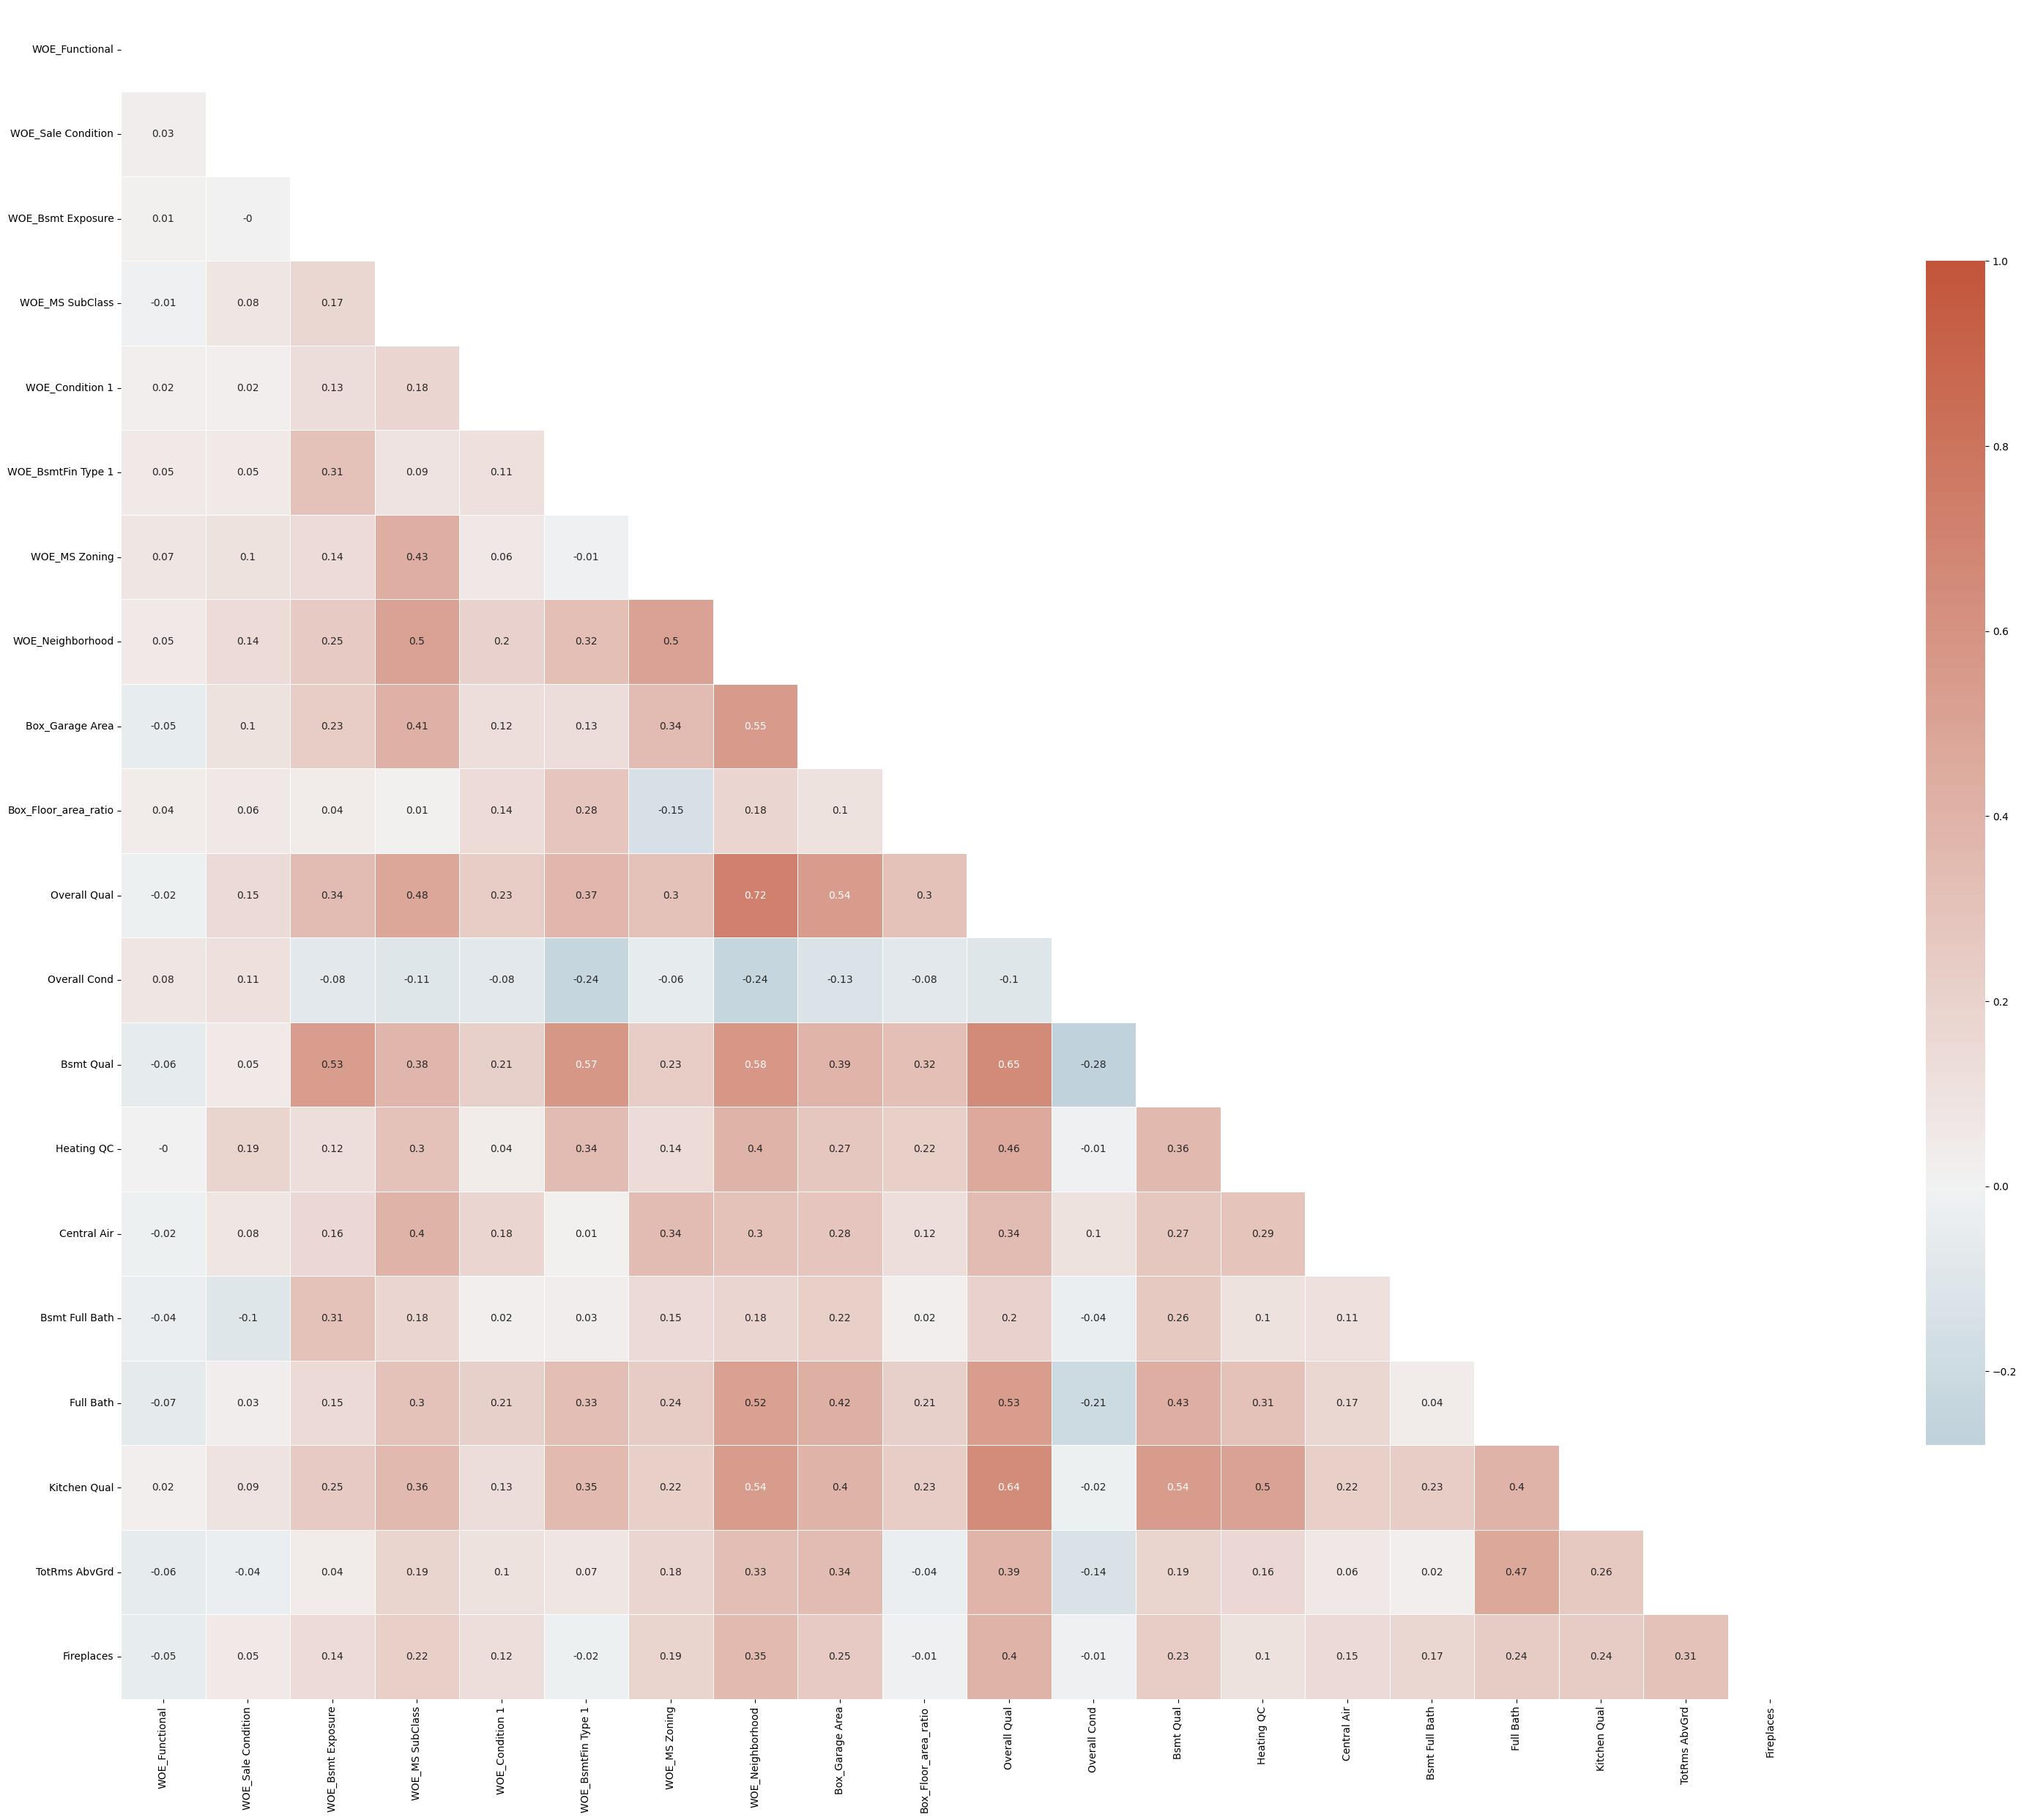

In [73]:
gp23diag.LinearDiagnostics(model_in = 'model3_elasticNet', data_in = X_test, target = y2_test, scoring_dict=scoring_dict, model_list=model_list)

*** Test data residuals statistics ***


,predicted,actual,residual
count,586.000000,586.000000,586.000000
mean,12.045850,12.031167,-0.014683
std,0.421621,0.403064,0.153725
min,10.929843,10.463103,-0.804787
25%,11.746702,11.784380,-0.109534
50%,12.055874,12.013670,-0.015600
75%,12.308862,12.276936,0.081338
max,13.200211,13.321214,0.453449


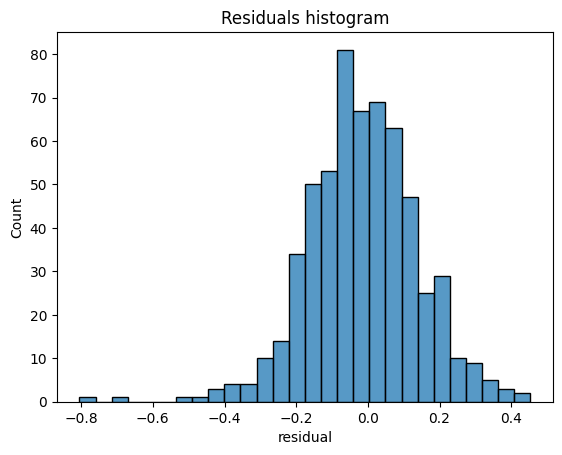

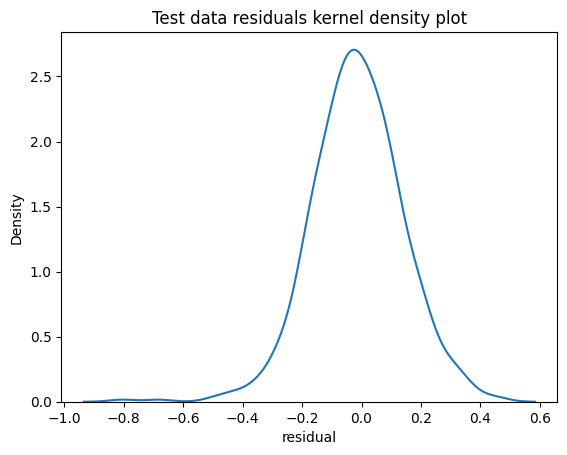

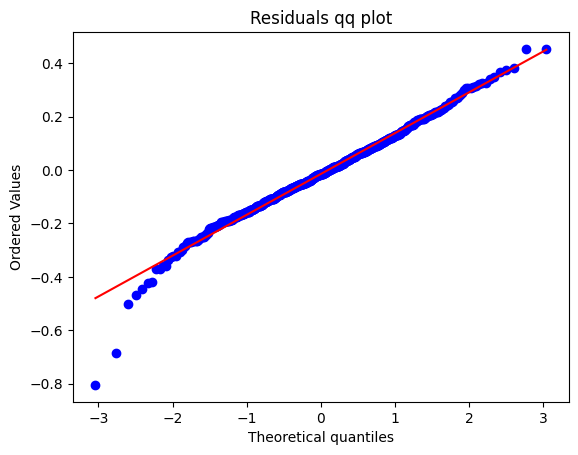

*** Jarque-Bera test for normality of residuals ***
[('Jarque-Bera', 75.68250676115903), ('Chi^2 two-tail prob.', 3.679192137836453e-17), ('Skew', -0.29663408337654484), ('Kurtosis', 4.657606024543771)]
On 0.05 significance level we  reject H0 about normal distribution of residuals.

Shapiro-Wilk test for normality
ShapiroResult(statistic=0.985346257686615, pvalue=1.2845827768614981e-05)
On 0.05 significance level we reject H0 that  residuals come from a normal distribution.

Anderson-Darling test for normality
Statistic: 0.813
Significance level - 15.000: 0.572 (Critical  Value), rejecting H0 that sample comes from normal  distribution.
Significance level - 10.000: 0.652 (Critical  Value), rejecting H0 that sample comes from normal  distribution.
Significance level - 5.000: 0.782 (Critical  Value), rejecting H0 that sample comes from normal  distribution.
Significance level - 2.500: 0.912 (Critical  Value), fail to reject H0 that sample comes from  normal distribution.
Significance le

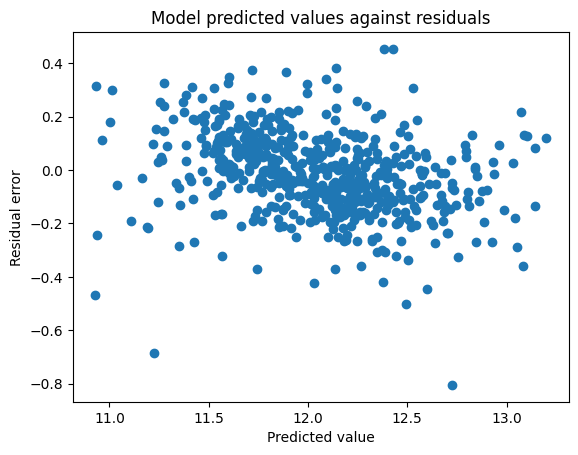

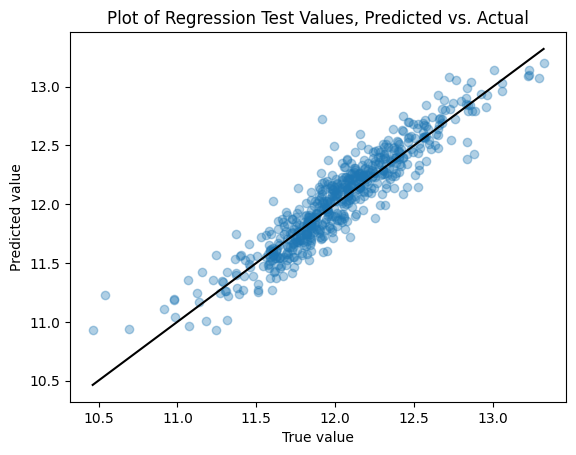

*** Breusch-Pagan homoscedasticity test***
[('Lagrange multiplier statistic', 129.24412671834196), ('p-value', 1.6961825271382334e-23), ('f-value', 16.298557138390372), ('f p-value', 5.03999659333005e-26)]
On 0.05 significance level we reject H0 and  assume heteroscedasticity of residuals.

*** Investigating Multicollinearity ***
*** Variance Inflation Factor (VIF) table***


,feature,VIF
0,WOE_MS SubClass,9.198537
1,WOE_Neighborhood,8.387129
2,Box_Garage Area,11.667508
3,Overall Qual,31.968714
4,Overall Cond,9.294928
5,Bsmt Qual,23.525612
6,Kitchen Qual,12.195062
7,TotRms AbvGrd,7.767165
8,Fireplaces,2.450352
9,Bathroom_total,5.923942


There is indication (VIF > 5) that multicollinearity is  present in the data.

*** Correlation Matrix ***


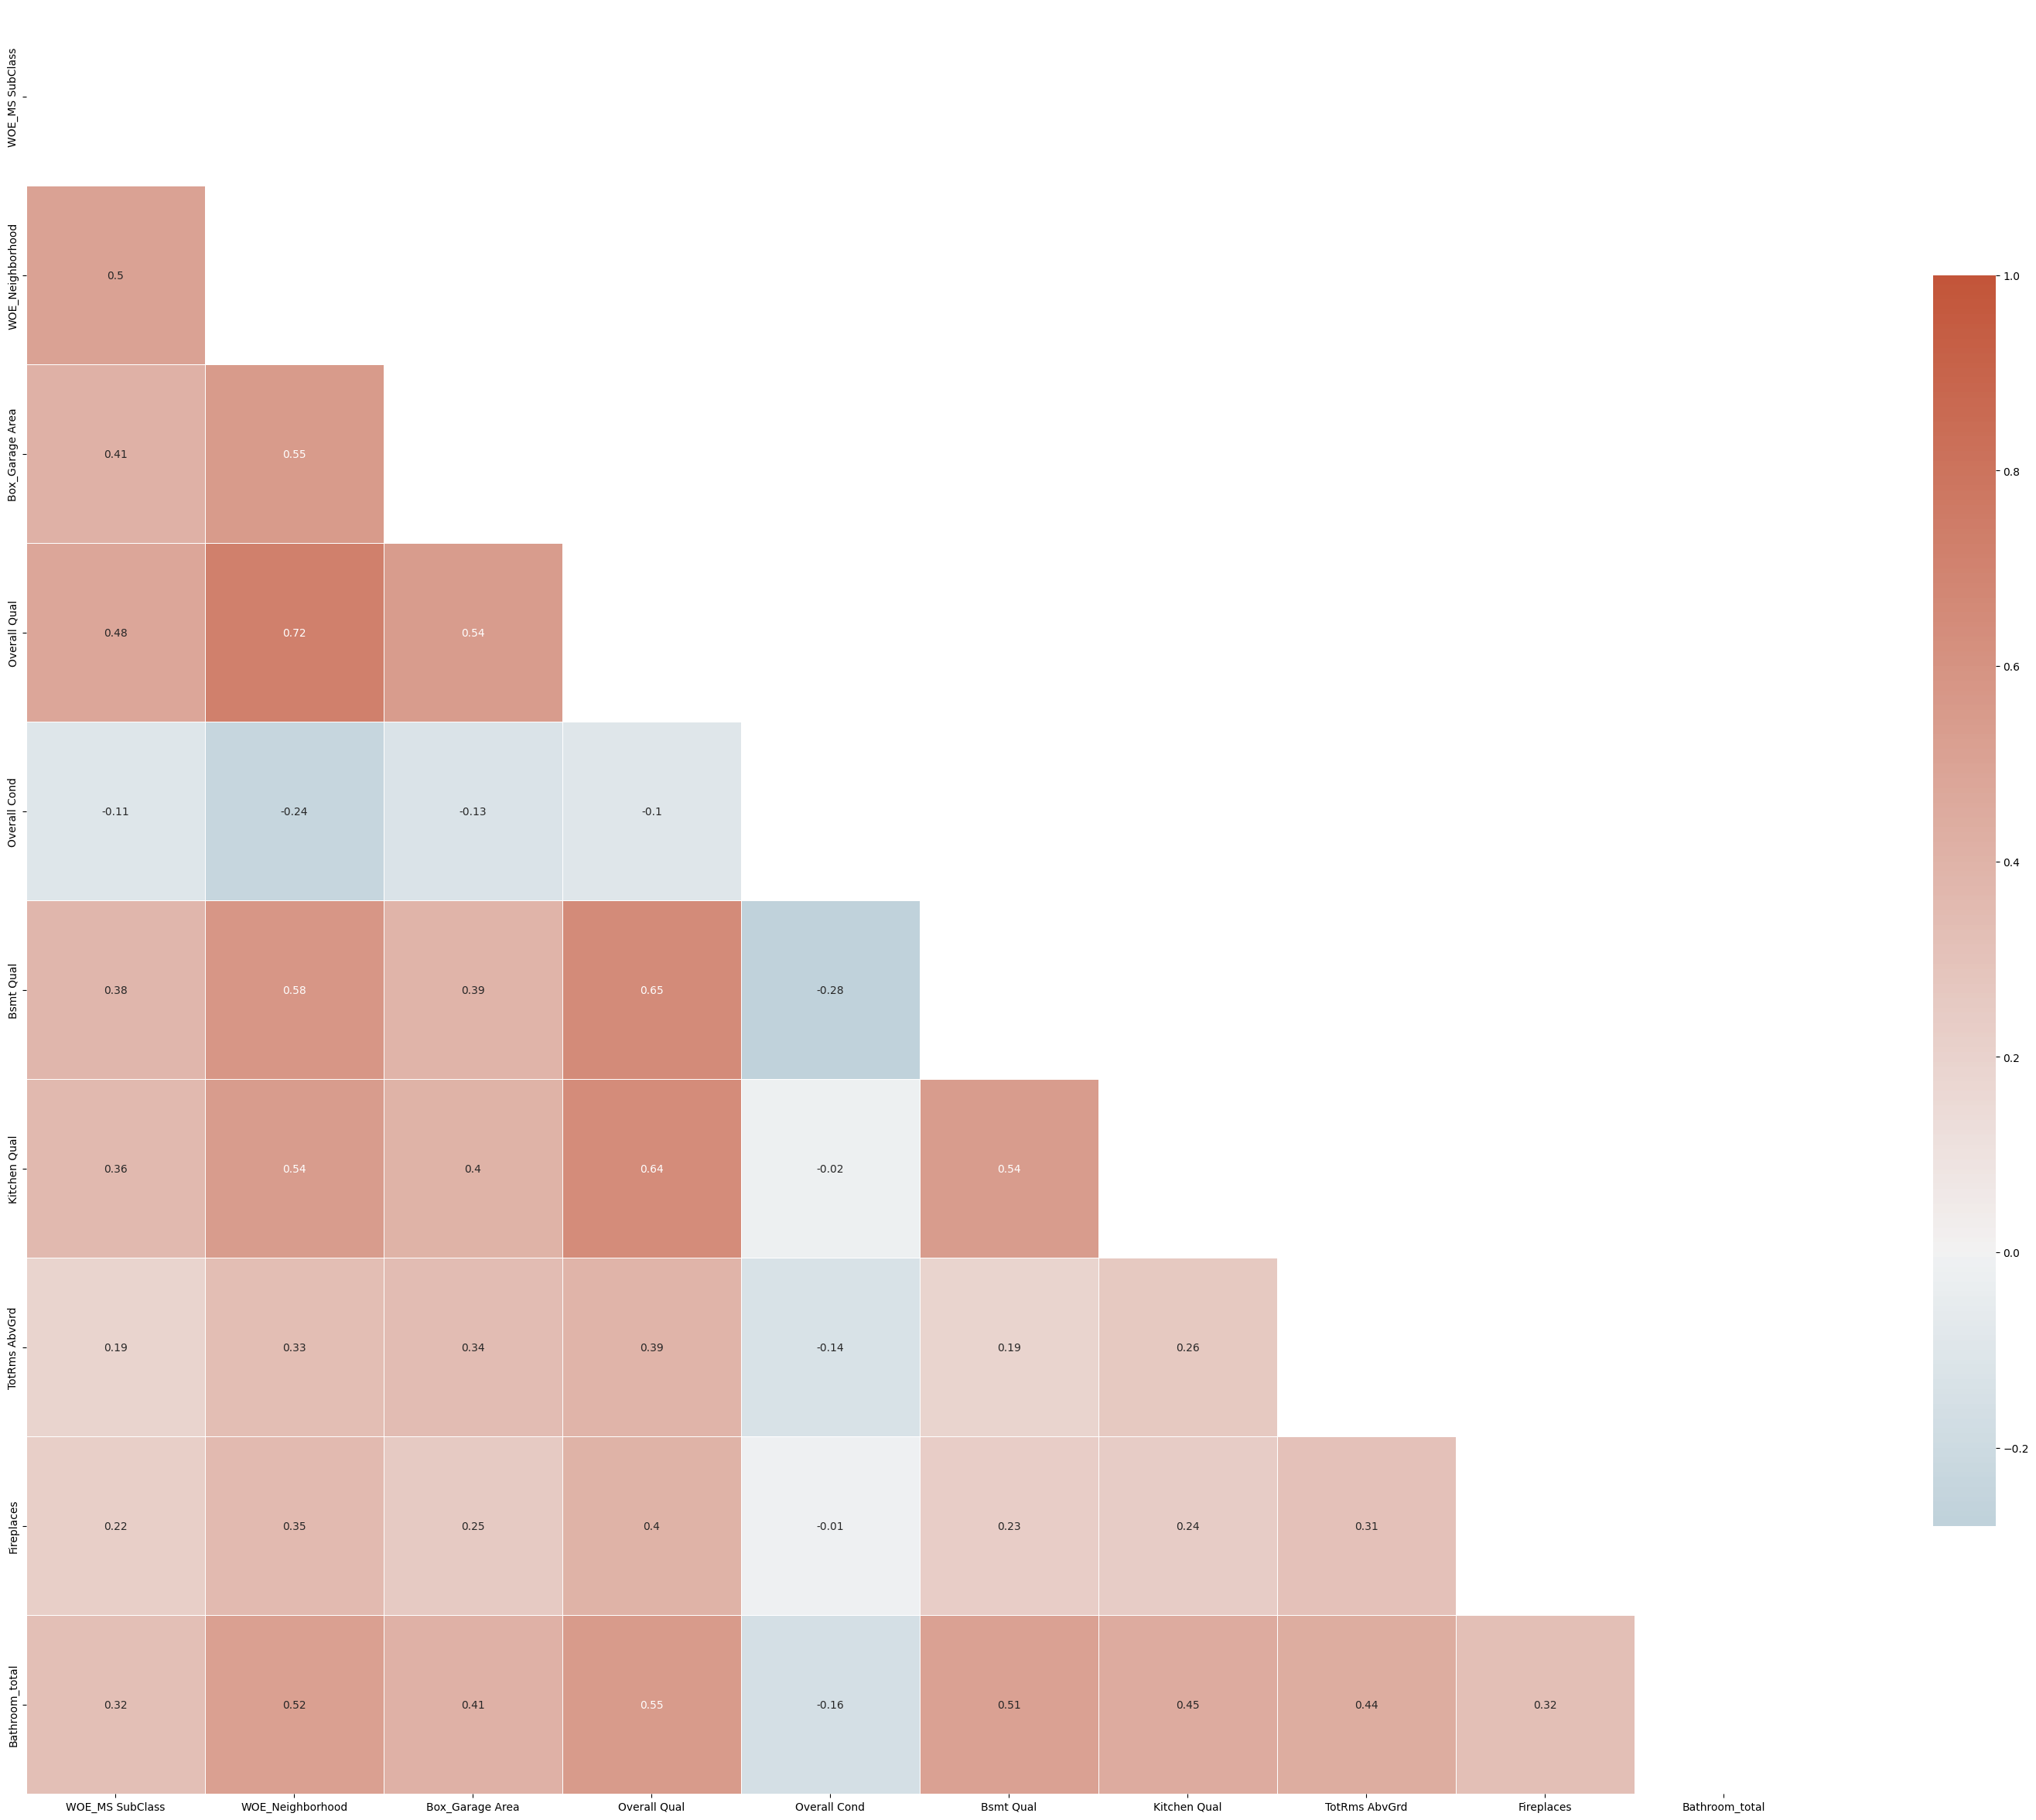

In [74]:
gp23diag.LinearDiagnostics(model_in = 'model6_theil', data_in = X_test, target = y2_test, scoring_dict=scoring_dict, model_list=model_list)

In [75]:
# Finishing project timer
toc_all = time()
# Total project computation time

print(f"Done in {tic_all - toc_all:.3f}s")
print(f"Done in {(tic_all - toc_all)/60.0:.3f}min")

Done in -24.861s
Done in -0.414min


Conclusions:

